In [1]:
import torch
from torch import nn
from models import resnet
path = '../../../data/bin/resnet_10.pth'
#model = resnet.transresnet(
    #sample_input_W=193,
    #sample_input_H=229,
    #sample_input_D=193,
    #shortcut_type='B',
    #no_cuda=False,
    #hidden_dim=512
#)
#net_dict = model.state_dict()
pretrain = torch.load(path, map_location='cuda:0')
# remove 'module.'
pretrain_dict = {k[7:]: v for k, v in pretrain['state_dict'].items() if k[7:] in net_dict.keys()}

#net_dict.update(pretrain_dict)
#model.load_state_dict(net_dict)
#model = model.cuda()

import sys
import os
import nibabel as nib
import numpy as np
import pandas as pd
sys.path.append('../..')
from src.utils.data import writePandas, getPandas, getConfig, getDict
from src.model.feature import load_radiomics
os.chdir('../../..')

data = getPandas('pat_data')
conf = getConfig('data')
train_idx = conf['indices']['pat']['train']
test_idx = conf['indices']['pat']['test']
keys = data['KEY'].values
paths = data['ANTs_Reg'].values
cats = data['CAT'].values
radiomics = getPandas('pat_ANTs_Reg_radiomic')
radiomics = radiomics.drop(['KEY'], axis=1)

train_keys = keys[train_idx]
train_paths = paths[train_idx]
train_radiomics = radiomics.iloc[train_idx]
radiomic_cols = [
    'rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis',
    'rTHA_original_glszm_LargeAreaHighGrayLevelEmphasis',
    'rSN_original_glcm_ClusterProminence',
    'rCAU_original_gldm_LargeDependenceHighGrayLevelEmphasis'
]
train_radiomics = train_radiomics[radiomic_cols].values
train_cats = cats[train_idx]
train_ages = data['AGE'].values[train_idx]/100
train_sexs = data['SEX'].values[train_idx]
train_scores = data['NUPDR3OF'].values[train_idx]
train_ledds = data['LEDD'].values[train_idx]/100
train_durations = data['DURATION'].values[train_idx]/100

In [2]:
from torch.utils.data import dataset, dataloader
class MyDataset(dataset.Dataset):
    def __init__(self, keys, paths, radiomics, cats, ages, sexs, scores, ledds, durations):
        self.keys = keys
        self.paths = paths
        self.radiomics = radiomics
        self.labels = cats
        self.ages = ages
        self.sexs = sexs
        self.scores = scores
        self.ledds = ledds
        self.durations = durations
    def __getitem__(self, index):
        key = self.keys[index]
        path = self.paths[index]
        radiomic = self.radiomics[index]
        img = nib.load(path).get_fdata()
        i_min = img.min()
        i_std = img.std()
        img = (img - i_min) / i_std
        img = np.expand_dims(img, axis=0)
        img = torch.from_numpy(img)
        tex = np.array(radiomic)
        tex = np.expand_dims(tex, axis=0)
        tex = torch.from_numpy(tex)
        demo = np.array([self.ages[index], self.sexs[index], self.scores[index], self.ledds[index], self.durations[index]])
        demo = torch.from_numpy(demo)
        label = self.labels[index]
        label = torch.from_numpy(np.array([label]))
        return img, tex, demo, label
    def __len__(self):
        return len(self.keys)

In [3]:
from torch import nn, optim
#loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.CrossEntropyLoss()
#lr = 1e-4
optim_params = []
#for name, param in model.named_parameters():
    #if 'train' in name:
        #param.requires_grad = True
        #optim_params.append(param)
    #else:
        #param.requires_grad = False
#optimizer = optim.Adam(model.parameters(), lr=lr)

data_set = MyDataset(train_keys, train_paths, train_radiomics, train_cats, train_ages, train_sexs, train_scores, train_ledds, train_durations)
data_loader = dataloader.DataLoader(data_set, batch_size=8, shuffle=True)
epoch = 20
from torcheval.metrics.aggregation.auc import AUC
metric = AUC()

In [4]:
loss_rec = []
lr_lsit = [1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_lsit:
    loss_list = []
    model = resnet.transresnet(
        sample_input_W=193,
        sample_input_H=229,
        sample_input_D=193,
        shortcut_type='B',
        no_cuda=False,
        hidden_dim=512
    )
    net_dict = model.state_dict()
    net_dict.update(pretrain_dict)
    model.load_state_dict(net_dict)
    model = model.cuda()
    for name, param in model.named_parameters():
        if 'train' in name:
            param.requires_grad = True
            optim_params.append(param)
        else:
            param.requires_grad = False
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for i in range(epoch):
        model.train()
        for img, tex, demo, label in data_loader:
            img = img.cuda().float()
            tex = tex.cuda().float()
            demo = demo.cuda().float()
            label = label.cuda().float()
            out = model(img, tex, demo)
            loss = loss_fn(out, label)
            #print(torch.sigmoid(out))
            #print(label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #print('epoch: {}, loss: {}'.format(i, loss.item()))
        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            total_loss = 0
            metric.reset()
            for img, tex, demo, label in data_loader:
                img = img.cuda().float()
                tex = tex.cuda().float()
                demo = demo.cuda().float()
                label = label.cuda().float()
                out = model(img, tex, demo)
                loss = loss_fn(out, label)
                total_loss += loss.item()
                print(torch.squeeze(out).cpu().detach().numpy(), torch.squeeze(label).cpu().detach().numpy())
                out = torch.sigmoid(out)
                metric.update(torch.squeeze(out), torch.squeeze(label))
                out = torch.round(out)
                out = out.cpu().detach().numpy()
                total += label.size(0)
                correct += (out == label.cpu().detach().numpy()).sum().item()
            loss_item = total_loss / len(data_loader)
            loss_list.append(loss_item)
            print('epoch: {}, loss: {}'.format(i, total_loss / len(data_loader)))
            print('acc: {}'.format(correct / total))
            print('auc: {}'.format(metric.compute().cpu().detach().numpy()))
    loss_rec.append(loss_list)

[-1.3057007 -1.3458043 -1.2667317 -1.3512723 -1.2775162 -1.305154
 -1.2885797 -1.2877855] [0. 1. 1. 1. 0. 0. 1. 0.]
[-1.2646937 -1.2736887 -1.3005861 -1.3151444 -1.3005267 -1.2832435
 -1.406449  -1.3010181] [0. 1. 0. 1. 1. 1. 1. 1.]
[-1.2644174 -1.2678305 -1.2960018 -1.2709136 -1.3405155 -1.2661902
 -1.288399  -1.2613388] [1. 0. 1. 1. 1. 1. 0. 0.]
[-1.3480448 -1.2938323 -1.2856776 -1.3230042 -1.2831346 -1.2792422
 -1.2748911 -1.2957629] [0. 0. 0. 1. 1. 0. 0. 0.]
[-1.2816943 -1.2790595 -1.3049084 -1.2903689 -1.2849168 -1.3037299
 -1.2926279 -1.3067272] [0. 0. 0. 0. 0. 0. 0. 0.]
[-1.3421988 -1.2751865 -1.3511897 -1.2688222 -1.2709279 -1.3592058
 -1.2808167 -1.2909725] [0. 1. 0. 1. 0. 1. 0. 0.]
[-1.3056897 -1.4503775 -1.3014361 -1.3463888 -1.3147621 -1.2873305
 -1.2974924 -1.3634515] [0. 1. 0. 1. 1. 1. 0. 0.]
[-1.2549955 -1.292485  -1.309064  -1.2802925 -1.288696  -1.2853944
 -1.2809328 -1.2621949] [1. 0. 1. 0. 0. 1. 0. 0.]
[-1.2781938 -1.2674966 -1.2619473 -1.3062644 -1.2859111 -1.270829

KeyboardInterrupt: 

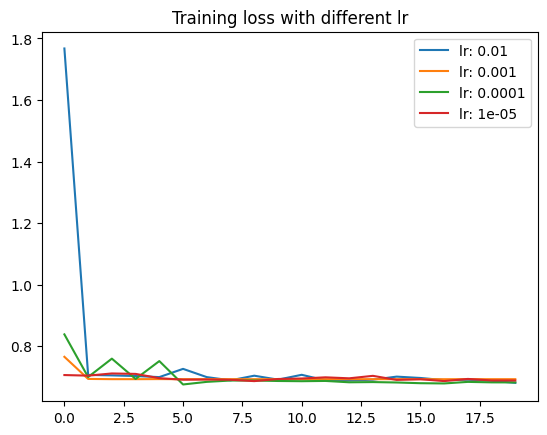

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in range(len(loss_rec)):
    loss_list = loss_rec[i]
    lr = lr_lsit[i]
    sns.lineplot(x=range(len(loss_list)), y=loss_list, legend='brief', label='lr: {}'.format(str(lr)))
plt.title('Training loss with different lr')
plt.show()

In [ ]:
#import torch
#import torch.nn as nn
#import torch.nn.functional as F

#class BaseNet(nn.Module):
    #def __init__(self):
        #super(BaseNet, self).__init__()
        #self.fc1 = nn.Linear(5, 64)
        #self.fc2 = nn.Linear(64, 8)
        #self.fc3 = nn.Linear(8, 1)
    #def forward(self, x):
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #return self.fc3(x)
#class TestDataset(dataset.Dataset):
    #def __init__(self, cats, ages, sexs, scores, ledds, durations):
        #super(TestDataset, self).__init__()
        #self.labels = cats
        #self.ages = ages
        #self.sexs = sexs
        #self.scores = scores
        #self.ledds = ledds
        #self.durations = durations
    #def __getitem__(self, index):
        #demo = np.array([self.ages[index], self.sexs[index], self.scores[index], self.ledds[index], self.durations[index]])
        #demo = torch.from_numpy(demo)
        #label = self.labels[index]
        #label = torch.from_numpy(np.array([label]))
        #return demo, label
    #def __len__(self):
        #return len(self.labels)
#test_set = TestDataset(train_cats, train_ages, train_sexs, train_scores, train_ledds, train_durations)
#test_loader = dataloader.DataLoader(test_set, batch_size=8, shuffle=True)
#model = BaseNet().cuda()
#lr = 1e-3
#optimizer = optim.Adam(model.parameters(), lr=lr)
#epoch = 2000
#for i in range(epoch):
    #model.train()
    #for demo, label in test_loader:
        #demo = demo.cuda().float()
        #label = label.cuda().float()
        #out = model(demo)
        #loss = loss_fn(out, label)
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
    ##print('epoch: {}, loss: {}'.format(i, loss.item()))
    #model.eval()
    #with torch.no_grad():
        #total = 0
        #correct = 0
        #total_loss = 0
        #metric.reset()
        #for demo, label in test_loader:
            #demo = demo.cuda().float()
            #label = label.cuda().float()
            #out = model(demo)
            #loss = loss_fn(out, label)
            #total_loss += loss.item()
            ##print(torch.squeeze(out).cpu().detach().numpy(), torch.squeeze(label).cpu().detach().numpy())
            #out = torch.sigmoid(out)
            #metric.update(torch.squeeze(out), torch.squeeze(label))
            #out = torch.round(out)
            #out = out.cpu().detach().numpy()
            #total += label.size(0)
            #correct += (out == label.cpu().detach().numpy()).sum().item()
        #print('epoch: {}, loss: {}'.format(i, total_loss))
        #print('acc: {}'.format(correct / total))
        #print('auc: {}'.format(metric.compute().cpu().detach().numpy()))

In [ ]:
#model.eval()
#with torch.no_grad():
    #img = nib.load(train_paths[0]).get_fdata()
    #i_min = img.min()
    #i_std = img.std()
    #img = (img - i_min) / i_std
    #img = np.expand_dims(img, axis=0)
    #img = np.expand_dims(img, axis=0)
    #img = torch.from_numpy(img)
    ##img = img.cpu().float()
    #img = img.cuda().float()
    #tex = np.array(train_radiomics[0])
    #tex = np.array([tex for i in range(252)])
    #tex = np.expand_dims(tex, axis=0)
    #tex = torch.from_numpy(tex)
    #tex = tex.cuda().float()
    #output = model(img, tex)
    #output = output.cpu().detach().numpy()
    #print(output)